# DDoS Binary Classification

In [3]:
# GPU Memory Release: Release GPU memory by restarting the kernel
import cupy as cp
import gc

cp.get_default_memory_pool().free_all_blocks()  # Free GPU memory

# Example of memory cleanup after processing
# del X_train_resampled, y_train_resampled  # Delete unused variables
gc.collect()  # Manually run garbage collection to free memory


476

In [1]:
# Start Dask Client
from dask.distributed import Client
# Start Dask Client with adjusted memory limits and local directory for spilling to disk
client = Client(n_workers=1, threads_per_worker=1, processes=False, memory_limit='10GB', local_directory='/home/jbenyam/PCAP-threatdetection-IOT/dataset/dasktempstorage')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.25.255.86:8787/status,
Dashboard: http://172.25.255.86:8787/status,Workers: 1
Total threads: 1,Total memory: 9.31 GiB
Status: running,Using processes: False
Comm: inproc://172.25.255.86/275397/1,Workers: 1
Dashboard: http://172.25.255.86:8787/status,Total threads: 1
Started: Just now,Total memory: 9.31 GiB
Comm: inproc://172.25.255.86/275397/4,Total threads: 1
Dashboard: http://172.25.255.86:33919/status,Memory: 9.31 GiB
Nanny: None,


### 10% Test Sample Model | DDoS

In [2]:
import dask_cudf
import cudf
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import os
import logging
import gc  # For garbage collection
from dask.distributed import Client

# Start Dask Client with reduced workers and memory limit
#client = Client(n_workers=1, threads_per_worker=1, processes=False, memory_limit='2GB', local_directory='/home/jbenyam/PCAP-threatdetection-IOT/tempstorage')

# Load the dataset in smaller chunks using Dask-cuDF with a smaller block size
data_path = '/home/jbenyam/PCAP-threatdetection-IOT/dataset/csv/balanced_multi_class_attack_traffic.csv'
df = dask_cudf.read_csv(data_path, blocksize="50MB")

# Sample only 10% of the dataset to test stability
df_sample = df.sample(frac=0.1)

# Repartition to reduce memory pressure
df_sample = df_sample.repartition(npartitions=2000)

# Setup logging
logging.basicConfig(
    filename='/home/jbenyam/PCAP-threatdetection-IOT/models/training_logs.log', 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Log the start of the process
logging.info("Starting the training process for binary classification (class 3) with a 10% sample of the dataset.")

# Define paths
save_model_path = '/home/jbenyam/PCAP-threatdetection-IOT/models'

# Create directory if it doesn't exist
os.makedirs(save_model_path, exist_ok=True)

# Log dataset loading
logging.info(f"10% Sample of the Dataset loaded.")

# Split data into features (X) and labels (y)
X = df_sample.drop(columns=['label'])
y = df_sample['label']

# Binary classification: Is this class 3 (yes/no)?
y_binary = (y == 3).astype(int)

# Train-test split (done in smaller chunks via Dask to avoid memory overflow)
X_train, X_test, y_train, y_test = train_test_split(X.compute(), y_binary.compute(), test_size=0.2, random_state=42)

# Convert to NumPy arrays for imblearn and sklearn compatibility
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

# Under-sample the majority class (non-class 3)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_np, y_train_np)

# Log the resampling process
logging.info(f"Resampling completed. New training set size: {X_train_resampled.shape[0]} samples.")

# Garbage collection after resampling
gc.collect()

# Train a binary classifier (Random Forest)
model = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all processors to speed up training
model.fit(X_train_resampled, y_train_resampled)

# Log the model training completion
logging.info("Model training completed.")

# Save the model using joblib before any evaluation
model_filename = os.path.join(save_model_path, 'DDoS_binary_model_class_3_sampled.joblib')
joblib.dump(model, model_filename)

# Log model saving
logging.info(f"Model for class 3 (sampled) saved to: {model_filename}")




2024-09-07 18:53:03,278 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:44157 (pid=233871) exceeded 95% memory budget. Restarting...
2024-09-07 18:53:03,301 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0): 'memory'}
2024-09-07 18:53:03,302 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:44157' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0)} (stimulus_id='handle-worker-cleanup-1725749583.3026567')
2024-09-07 18:53:03,472 - distributed.nanny - WARNING - Restarting worker
2024-09-07 18:53:11,178 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36915 (pid=233884) exceeded 95% memory budget. Restarting...
2024-09-07 18:53:11,197 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0): 'memory'}
2024-09-07 18:53:11,198

2024-09-07 18:53:03,310 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0),)
2024-09-07 18:53:11,210 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0),)
2024-09-07 18:53:19,406 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0),)
2024-09-07 18:53:27,609 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('repartitiontofewer-f24d7b4478347b4a430150c84bc7ad0d', 0),)


##### Training on Sample Completed without issue, memory management was concerning as each worker exceeded memory budget:
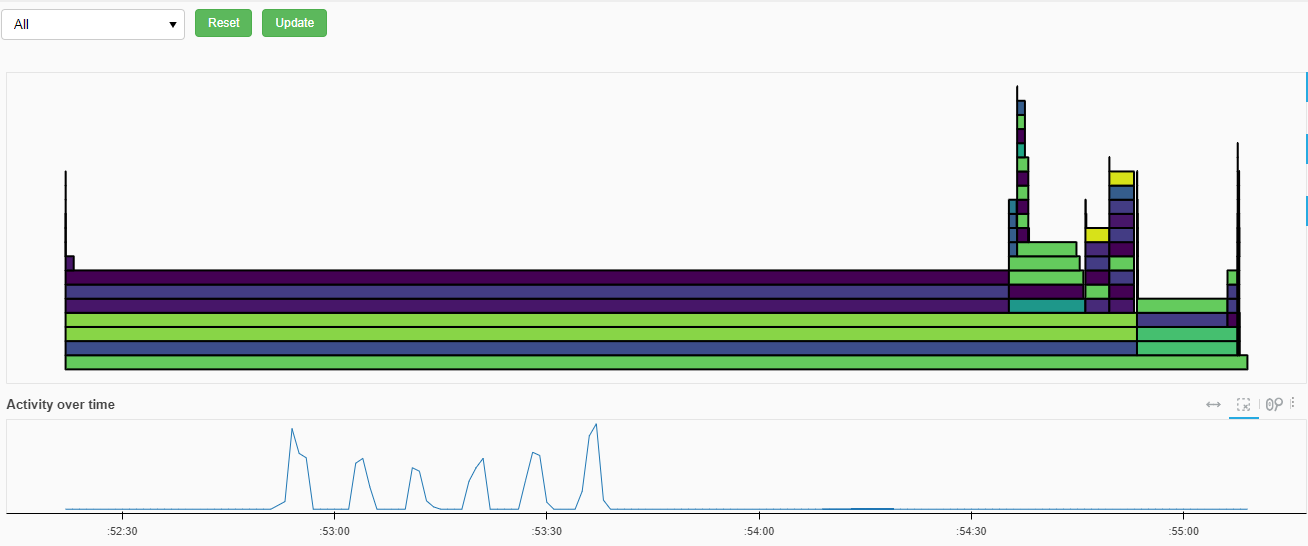

#### Model Evaluation

In [ ]:
# Clear resampled data to free memory
del X_train_resampled, y_train_resampled
gc.collect()


In [4]:
# Convert test data to NumPy arrays for model evaluation
X_test_np = X_test.to_numpy()

# Evaluate the model (optionally handle this separately)
y_pred = model.predict(X_test_np)


In [5]:
# Now proceeding with evaluation separately, after confirming the model is saved


# Classification and evaluation (Optional: Can be moved to a separate script or function)
from sklearn.metrics import classification_report, confusion_matrix
classification_rep = classification_report(y_test.to_numpy(), y_pred)
print(classification_rep)
logging.info("Classification report:\n" + classification_rep)

conf_matrix = confusion_matrix(y_test.to_numpy(), y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
logging.info(f"Confusion matrix:\n{conf_matrix}")

# End of process log
logging.info("Training and evaluation process for class 3 (sampled) completed.")

# Clear GPU memory and garbage collection
del X_test, y_test, X, y
gc.collect()


              precision    recall  f1-score   support

           0       0.82      0.86      0.84    233823
           1       0.83      0.79      0.81    200424

    accuracy                           0.82    434247
   macro avg       0.82      0.82      0.82    434247
weighted avg       0.82      0.82      0.82    434247

Confusion Matrix:
[[200414  33409]
 [ 42842 157582]]


0

#### Classification Report | Interpretation | DDoS Sampled

2. Confusion Matrix Interpretation:
The confusion matrix provides a detailed view of how well the model performed in terms of true positives, true negatives, false positives, and false negatives.  




|--------------|Predicted Class 0   |Predicted Class 1|
|--------------|--------------------|-----------------|
|Actual Class 0|    200,414         |       33,409    |
|Actual Class 1|    42,842          |     157,582     |

**Key Takeaways:**
- True Negatives (TN): 200,414 (Correctly predicted as Non-DDoS)
- False Positives (FP): 33,409 (Predicted as DDoS, but actually Non-DDoS)
- False Negatives (FN): 42,842 (Predicted as Non-DDoS, but actually DDoS)
- True Positives (TP): 157,582 (Correctly predicted as DDoS)

1. Performance Analysis:
False Negatives (42,842): These are cases where the model predicted Non-DDoS, but they were actual DDoS samples. This indicates that around 21% of the actual DDoS attacks were missed by the model, which could be concerning for an intrusion detection system.
False Positives (33,409): These are cases where the model predicted a DDoS attack, but they were actually Non-DDoS samples. This indicates some level of overprediction of DDoS attacks, which can result in false alarms.

1. Strengths:
Balanced Performance: The precision, recall, and F1-scores are quite similar between class 0 and class 1, which indicates the model is performing similarly across both classes.
Good Accuracy: With an accuracy of 82%, the model is performing reasonably well in distinguishing between DDoS and Non-DDoS packets.

1. Potential Areas for Improvement:
**Reducing False Negatives:** The recall for class 1 (DDoS) is 0.79, meaning 21% of actual DDoS attacks are missed. Reducing this percentage could significantly improve the model's effectiveness in detecting attacks.
**Handling Imbalance:** If class 0 and class 1 are not balanced (as is common with network traffic data), this might lead to the model underperforming on the minority class (DDoS in this case). You might consider techniques like SMOTE or cost-sensitive learning to improve recall for class 1.

### Full Data Model Training (TBD) 

In [2]:
import dask_cudf
import cudf
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
import logging
import gc  # For garbage collection
from dask.distributed import Client
import dask_cudf

# Start Dask Client
# client = Client()

# Load the dataset in smaller chunks using Dask-cuDF with a smaller block size
data_path = '/home/jbenyam/PCAP-threatdetection-IOT/dataset/csv/balanced_multi_class_attack_traffic.csv'
df = dask_cudf.read_csv(data_path, blocksize="50MB")

# Repartition to reduce memory pressure
#df = df.repartition(npartitions=1000)

# Setup logging
logging.basicConfig(
    filename='/home/jbenyam/PCAP-threatdetection-IOT/models/training_logs.log', 
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Log the start of the process
logging.info("Starting the training process for binary classification (class 3).")

# Define paths
save_model_path = '/home/jbenyam/PCAP-threatdetection-IOT/models'

# Create directory if it doesn't exist
os.makedirs(save_model_path, exist_ok=True)

# Log dataset loading
logging.info(f"Dataset loaded with {len(df)} records.")

# Split data into features (X) and labels (y)
X = df.drop(columns=['label'])
y = df['label']

# Binary classification: Is this class 3 (yes/no)?
y_binary = (y == 3).astype(int)

# Compute the Dask DataFrames to bring them into memory as pandas DataFrames
X_pandas = X.compute().to_pandas()
y_pandas = y_binary.compute().to_pandas()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pandas, y_pandas, test_size=0.2, random_state=42)

# Log the dataset split
logging.info(f"Data split into training and testing sets: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples.")

# Under-sample the majority class (non-class 3)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Log the resampling process
logging.info(f"Resampling completed. New training set size: {X_train_resampled.shape[0]} samples.")

# Garbage collection after resampling
gc.collect()

# Train a binary classifier (Random Forest)
model = RandomForestClassifier(random_state=42, n_jobs=10)  # Use all processors to speed up training
model.fit(X_train_resampled, y_train_resampled)

# Log the model training completion
logging.info("Model training completed.")

# Save the model using joblib
model_filename = os.path.join(save_model_path, 'DDoS_binary_model_class_3.joblib')
joblib.dump(model, model_filename)

# Log model saving
logging.info(f"Model for class 3 saved to: {model_filename}")

# Clear resampled data to free memory
del X_train_resampled, y_train_resampled
gc.collect()


2024-09-07 20:20:49,463 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.61 GiB -- Worker memory limit: 9.31 GiB
2024-09-07 20:20:50,243 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7.52 GiB -- Worker memory limit: 9.31 GiB
2024-09-07 20:20:59,466 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.57 GiB -- Worker memory limit: 9.31 GiB
2024-09-07 20:21:09,560 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory le

: 

In [ ]:


# Evaluate the model
y_pred = model.predict(X_test)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
logging.info("Classification report:\n" + classification_rep)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
logging.info(f"Confusion matrix:\n{conf_matrix}")

# End of process log
logging.info("Training and evaluation process for class 3 completed.")

# Clear GPU memory and garbage collection
del X_test, y_test, X, y
gc.collect()

